Diversification: eliminating unrewarded idiosyncratic risks.  

Limits of Diversification:  
diversification will fail you if when you need it the most. Trying to address this limitation by "improving" diversification simply won't work. Almost by definition one cannot diversify systematic risk. 

Hedging is the only effective way to have downside protection. 

insurance is dynamic hedging. 

CPPI: constant proportion portfolio insurance  
Multiplier M, wealth preservation floor x%. Allocation to risky asset: M*(1-x%)   
Gap risk: materializes iff the loss on the risky portfolio relative to the save portfolio exceeds 1/M within the trading interval.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import edhec_risk_kit_129 as erk

# load the industry returns and the total market index 
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [4]:
risky_r = ind_return["2000":][['Steel', 'Fin', 'Beer']]
safe_r = pd.DataFrame().reindex_like(risky_r) #give safe_r the same shape as risky_r
safe_r[:] = 0.03/12

In [6]:
start = 1000
floor = 0.8

# 1. cushion: asset value - floor value
# 2. allocation to safe and risky -> m*risk budget
# 3. recompute asset value

erk.compound(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [7]:
# %timeit 

### CPPI

In [9]:
date = risky_r.index
n_steps = len(date)
account_val = start
floor = start * floor
m = 3

account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_val - floor) / account_val
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    safe_w = np.maximum(1-risky_w, 0)
    
    risky_alloc = account_val * risky_w
    safe_alloc = account_val * safe_w
    
    # update the account value
    account_val = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc * (1+safe_r.iloc[step])
    
    cushion_history.iloc[step] = cushion
    account_history.iloc[step] = account_val
    risky_w_history.iloc[step] = risky_w

In [10]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


### Random Walk Generation  

$\frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma \sqrt{dt}\xi _t$

In [15]:
def gbm(n_years = 10, n_scenarios = 1000, mu = 0.07, sigma = 0.15, steps_per_year = 12, s_0 = 100.0):
    
    dt = 1 / steps_per_year
    n_steps = n_years * steps_per_year
    xi = np.random.normal(size=(n_steps, n_scenarios))
    rets = mu * dt + sigma * np.sqrt(dt)*xi
    rets = pd.DataFrame(rets)
    
    # to prices
    prices = s_0 * (1+rets).cumprod(axis = 1)
    return prices

In [16]:
p = gbm(10, n_scenarios=3)
p.shape

(120, 3)

In [17]:
p.head()

,0,1,2
0,101.515442,103.392219,106.376413
1,102.769878,100.176365,109.242971
2,90.242372,90.218719,95.475861
3,105.474899,112.095220,116.517047
4,93.759464,91.451474,97.193932


<AxesSubplot:>

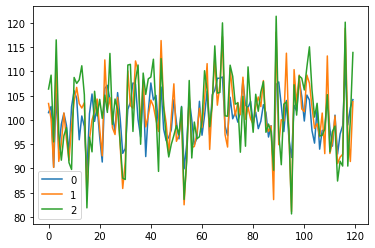

In [18]:
p.plot()

In [22]:
def gbm1(n_years = 10, n_scenarios = 1000, mu = 0.07, sigma = 0.15, steps_per_year = 12, s_0 = 100.0):
    
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year)
    rets_plus_1 = np.random.normal(loc=1+mu*dt, scale=sigma*np.sqrt(dt),size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    print(rets_plus_1.cumprod(axis=1))
    # to prices
    prices = s_0 * pd.DataFrame(rets_plus_1).cumprod(axis=1)
    return prices